# Playing Time Influenced by Gender as a Predictor for Game Newsletter Subscription
By Group 23 (Aayush, Kathleen, QingYou, Gordon) 

## Introduction
#### Background:

Frank Wood is leading a research group in computer science at UBC and collecting data about the ways people play video games by hosting a MineCraft server that automatically tracks player analytics. The group needs to strategically target recruitment efforts for players and ensure that their computational resources are sufficient to support their player base. They've accumulated the `players` dataset which we will work with to draw findings about player activity based on demographics.

#### Question

**General Question:**

What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? (Question 1)

**Specific Interpretation:**

To what extent can a player's played hours and age predict subscription status in the players dataset? 

#### Dataset Overview

To answer this question, we will use the `players` dataset to create a KNN classifier that predicts subscription status. 

The `players` dataset includes 196 observations and 7 variables describing player demographic information and activity on the server. The following variables are included in the full dataset:

| Variable | Type | Description |
|--------|----|-----------|
| `experience` | character | Player's skill level |
| `subscribe` | logical | Indicates whether player subscribes to a game-related newsletter |
| `hashedEmail` |character | Unique identifier for each player (hashed) |
| `played_hours` | numeric | Total accumulated play time on the server in hours |
| `name` | character | Player's name |
| `gender` | character | Gender |
| `Age` | numeric | Player's age |

To answer our question, we are only interested in `subscribe`, `played hours`, and `age`.

**Response variable:**
* `subscribe`: Indicates whether a player is subscribed to a game-related newsletter, each value can be interpreted as one of two classes. 

**Explanatory variables:**
* `played hours`: The total number of hours a player has logged on the server. This is reliable as it is automatically tracked.
* `age`: The self-reported age in years of a player. There could be response bias or incorrect information in this data.

Age has two NA values. We will handle this by dropping those observations.

## Methods and Results

We will be training a KNN classifier off our player data in order to see if we can predict subscription status based on a player's played hours and age.

#### Step 1: Loading Libaries and Data

We'll first load some libraries that we'll (absolutely or possibly) need. Then we'll read in our players dataset using a URL so that this project is able to run on different devices.

In [9]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

In [4]:
players <- read_csv('https://raw.githubusercontent.com/kathleenramsey/dsci100_group23/main/Project%20Planning%20Players.csv')
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience subscribe
1   Pro         TRUE    
2   Veteran     TRUE    
3   Veteran    FALSE    
⋮   ⋮          ⋮        
194 Amateur    FALSE    
195 Amateur    FALSE    
196 Pro         TRUE    
    hashedEmail                                                     
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
3   b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
⋮   ⋮                                                               
194 d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb
195 f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436
196 d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11
    played_hours name      gender            Age
1   30.3         Morgan    Male               9 
2    3.8         Christian Male              17 
3    0.0         Blake     Male              17 
⋮   ⋮            ⋮         ⋮                 ⋮  
194 0.0          Dylan     Prefer not to say 17 
195 2.3          Harlow    Male              17 
196 0.2          Ahmed     Other             NA

#### Step 2: Wrangling and Preparing Data

After loading in the data, we'll tidy it by changing the datatypes of `experience`, `gender`, and `subscribe` into factor variables. We'll also go on and remove the two rows that have missing `Age` variables.

In [6]:
players_tidy <- players |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(is.na(Age) == FALSE) |>
    select(Age, played_hours, subscribe)
players_tidy

Age played_hours subscribe
1    9  30.3         TRUE     
2   17   3.8         TRUE     
3   17   0.0         FALSE    
⋮   ⋮   ⋮            ⋮        
192 22  0.3          FALSE    
193 17  0.0          FALSE    
194 17  2.3          FALSE

#### Step 3: Summary of Exploratory Data

Below we are getting some statistics on the variables from our players dataset we will use for our analysis. We can see roughly 3/4 of the players are subscribed to a game-related newspaper. We can see that the mean age of the players are around 20 and that there is a strong skew to low values in `played_hours` with many players having 0 played hours.

In [17]:
subscription_proportion <- players_tidy |>
    group_by(subscribe) |>
    summarize(count = n()) |>
    mutate(percentage = (count / sum(count)) * 100)
subscription_proportion

age_summary <- players_tidy |>
    summarize(mean = mean(Age, na.rm = TRUE),
              sd = sd(Age, na.rm = TRUE),
              median = median(Age, na.rm = TRUE),
              min = min(Age, na.rm = TRUE),
              max = max(Age, na.rm = TRUE))
age_summary

played_hours_summary <- players_tidy |>
    summarize(mean = mean(played_hours, na.rm = TRUE),
              sd = sd(played_hours, na.rm = TRUE),
              median = median(played_hours, na.rm = TRUE),
              min = min(played_hours, na.rm = TRUE),
              max = max(played_hours, na.rm = TRUE))
played_hours_summary

subscribe count percentage
1 FALSE      52   26.80412  
2 TRUE      142   73.19588

mean     sd       median min max
1 20.52062 6.174667 19     8   50

mean     sd       median min max  
1 5.904639 28.49793 0.1    0   223.1

#### Step 4: Exploratory Visualizations

We'll explore some vizualisations to better understand our variables and their relationships with each other. 

* **Figure 1: `played_hours` distribution**

The histogram below shows what we mentioned earlier about the pretty substantial inbalance in `played_hours` amongst players. A huge majority of players have single-digit and near 0 hours played. Included in the plot is the distinction between those who are subscirbed and those who aren't subscribed to a game-related newspaper. We can see that ,unsurprisingly, most of the those not subscribed have lower or no hours.

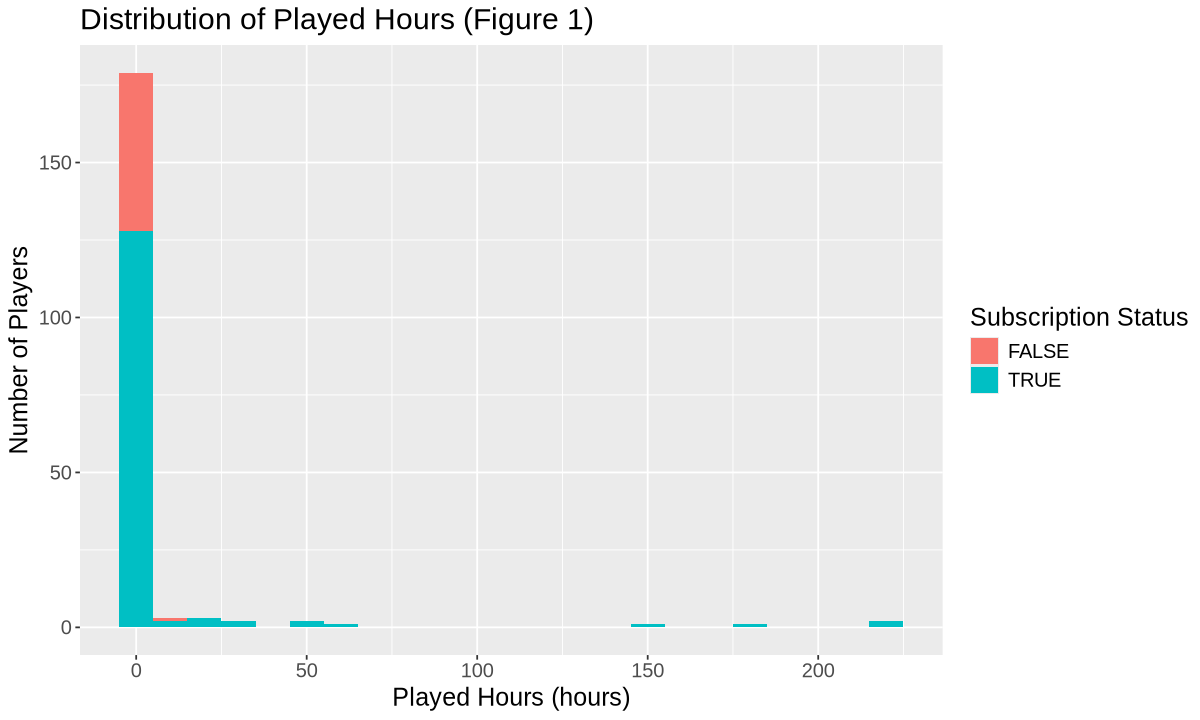

In [48]:
options(repr.plot.height = 6, repr.plot.width = 10)

player_hist <- players_tidy |>
    ggplot(aes(x=played_hours, fill=subscribe)) +
    geom_histogram(binwidth=10) +
    labs(x='Played Hours (hours)',
         y='Number of Players',
         fill='Subscription Status',
         title = 'Distribution of Played Hours (Figure 1)') +
    theme(text = element_text(size = 15)) 
player_hist

* **Figure 2: Distribution of `Age`**

The histogram below shows us the distribution of the age of the players. We can see that most of our players are around their mid-teens to early twenties. There is no distinct pattern visible here with how much of each group subscribes/isn't subscribed. 

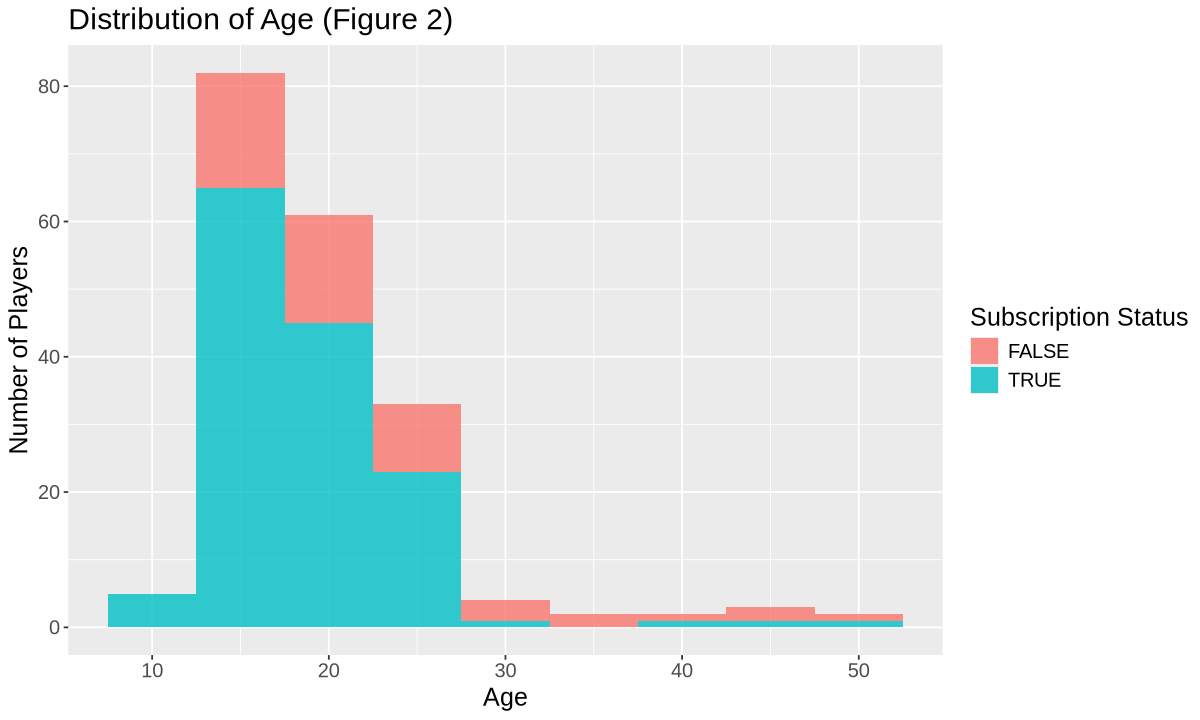

In [47]:
options(repr.plot.height = 6, repr.plot.width = 10)

age_hist <- players_tidy |>
    ggplot(aes(x=Age, fill=subscribe)) +
    geom_histogram(binwidth=5, alpha = 0.8) +
    labs(x='Age',
         y='Number of Players',
         fill='Subscription Status',
         title = 'Distribution of Age (Figure 2)') +
    theme(text = element_text(size = 15)) 
age_hist

* **Figure 3: `played_hours` vs `Age` Scatterplot**

Looking at the plot below, we can see that there is no clear linearity or dominant relationship between `Age` and `played_hours`. There is also no strong pattern of which observations are more likely to subscribe or not subscribe which is concerning. We see a peak around the mid-teens to early twenties where we have our highest played hours. But other than that most of observations have lower played hours which we mentioned in figure 1.

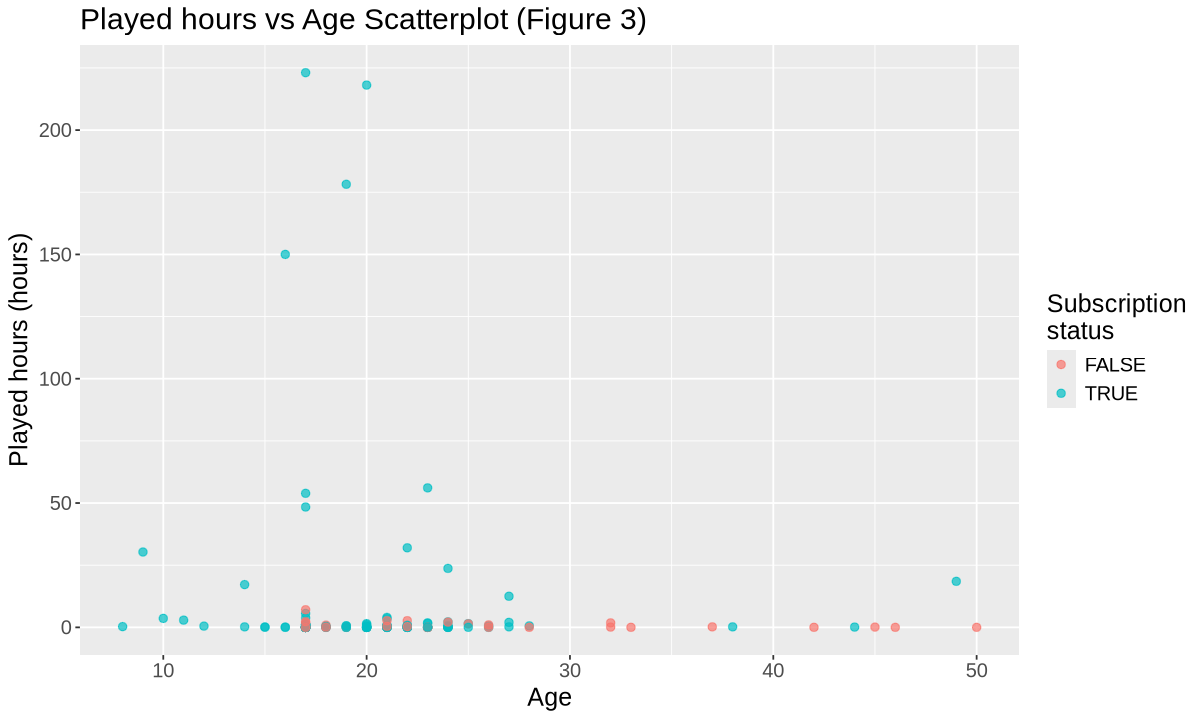

In [20]:
options(repr.plot.height = 6, repr.plot.width = 10)

played_hours_vs_age <- players_tidy |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
        geom_point(alpha = 0.7, size = 2) +
        labs(title = "Played hours vs Age Scatterplot (Figure 3)",
             color = "Subscription\nstatus",
             x = "Age",
             y = "Played hours (hours)") +
        theme(text = element_text(size = 15))
played_hours_vs_age

#### Step 5: Data Analysis

The code below follows the following steps: 
* Set the seed to ensure reproduceability for the split and the vfold.
* Split our data into a training and testing split so we can accurately assess our predictive model later (prop = 0.75).
* Create a tibble containing the range different k-values to tune our KNN classification model.
* Create vfold with v = 5 to gage best k-value.
* Create temporary tuning KNN classification model.
* Create recipe containing our variables and training data, scaling/centering variables along the way.
* Combine using workflow along with `tune_grid`.
* Collect metrics, plot accuracy, and get best k-value.

The results show that the best k-value is k = 25 with an accuracy of 0.745....

[1] 2

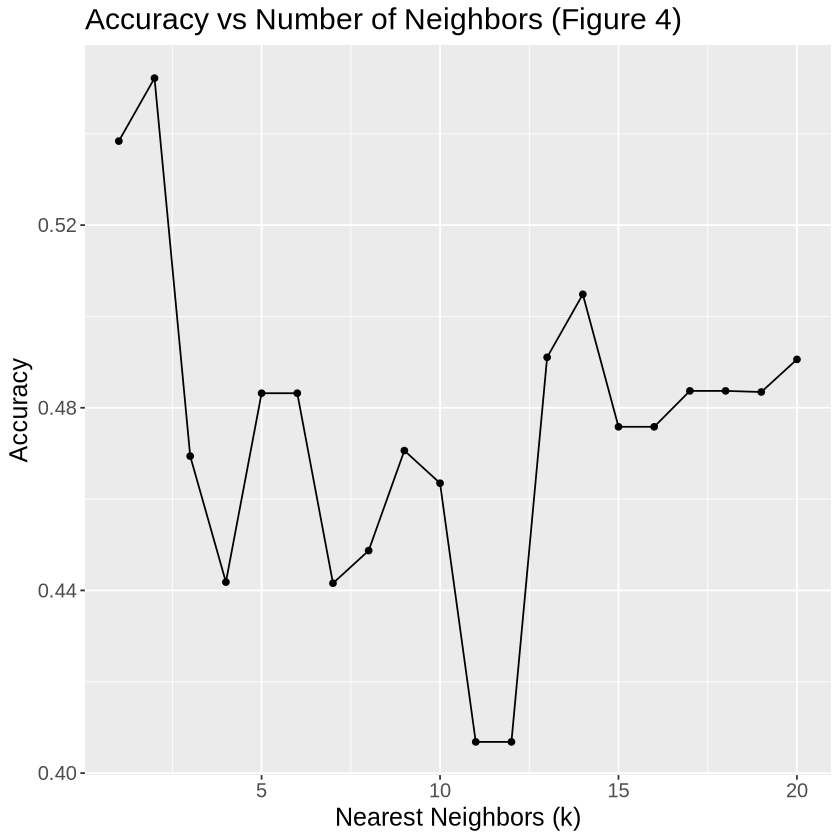

In [13]:
set.seed(23) 

players_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

k_vals <- tibble(neighbors = c(1:20))

knn_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_upsample(subscribe, over_ratio = 1, skip = TRUE) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = knn_vfold, grid = k_vals)

knn_metrics <- knn_workflow |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

cross_val_plot <- knn_metrics |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "Accuracy vs Number of Neighbors (Figure 4)",
             x = "Nearest Neighbors (k)",
             y = "Accuracy") + 
        theme(text = element_text(size = 15))
cross_val_plot

best_k <- knn_metrics |>
    arrange(desc(mean)) |>
    select(neighbors) |>
    slice(1) |>
    pull()
best_k

Using the optimal k-value found earlier, we'll now train our new classifier model accordingly and assess its effectiveness.
* Create new model spec with `best_k` as the k_value.
* Combine model spec with our recipe and data.
* Apply model onto test set and bind predictions.
* Assess acccuracy and create confusion matrix for further analysis.

Looking at our results, we can see that our overall accuracy is around 0.735. Now looking at the accuracy alone cannot accurately (see what I did there) describe the model's overall effectiveness. Looking at the confusion matrix, we'll see that our model had made no `FALSE` predictions which goes back to our concerns from figures 1-3.

In [21]:
set.seed(23)

best_k_model <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_workflow2 <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(best_k_model) |>
    fit(data = players_train)

player_test_pred <- knn_workflow2 |>
    predict(players_test) |>
    bind_cols(players_test) 

player_pred_accuracy <- player_test_pred |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric=='accuracy')
player_pred_accuracy

players_pred_matrix <- player_test_pred |>
        conf_mat(truth = subscribe, estimate = .pred_class)
players_pred_matrix

.metric  .estimator .estimate
1 accuracy binary     0.3265306

          Truth
Prediction FALSE TRUE
     FALSE     4   24
     TRUE      9   12

#### Step 6: Visualizing Our Analysis

To kinda visualize our analysis, we've created this visual (taken from the textbook). The colored regions represent the regions where our KNN classifier will predict `TRUE`.

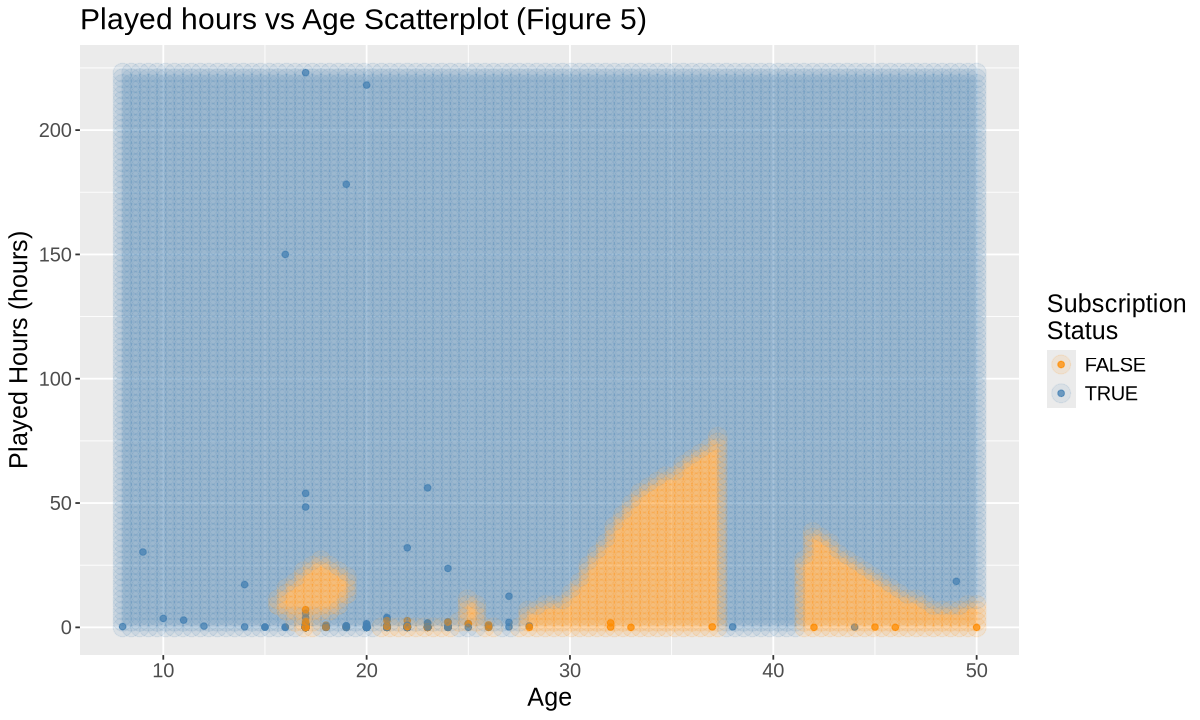

In [84]:
# create the grid of area/smoothness vals, and arrange in a data frame
age_grid <- seq(min(players_tidy$Age),
                max(players_tidy$Age),
                length.out = 100)
ph_grid <- seq(min(players_tidy$played_hours),
                max(players_tidy$played_hours),
                length.out = 100)
asgrid <- as_tibble(expand.grid(Age = age_grid,
                                played_hours = ph_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_workflow2, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |>
  rename(subscribe = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = players_tidy,
             mapping = aes(x = Age,
                           y = played_hours,
                           color = subscribe),
             alpha = 0.75) +
  geom_point(data = prediction_table,
             mapping = aes(x = Age,
                           y = played_hours,
                           color = subscribe),
             alpha = 0.1,
             size = 5) +
  labs(color = "Subscription\nStatus",
       x = "Age",
       y = "Played Hours (hours)",
       title = "Played hours vs Age Scatterplot (Figure 5)") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 15))

wkflw_plot

### Summary of Results (Accuracy):

**Accuracy: 0.326**

After undergoing standard data preparation and model training and testing, we are left with a very low testing accuracy. This indicates to us that a player's age and played hours are not correlated to subscription class.

This is an interesting finding-- we expected that there would be a stronger correllation between our chosen characteristics and the `subscribe` variable. This would maybe cause us to reconsider any age biases that might be in place or to assume that a player's experience will not predicate subscribing to the newsletter.

We wonder if the very limited players dataset is sufficient volume of information to show any trend that might be in these variables, and if more observations over longer periods of time would reveal a different trend.